# Evaluating the Predictive Capabilities of "Predictive Testing"
## Predicting NCLEX Success for Nursing Students
Author: Alexander Stachniak

# Data Preparation Stage
Data preparation is an important part of any predictive modeling. The original data was gathered and anonymized on-site. In order to protect the privacy and confidentiality of the data, the data gathering stage will not be discussed in depth. No cleaning was done with the original data before it was pickled and saved.
## Goals
* Prepare a target dataset
* Clean the data and perform necessary preprocessing steps
* Review training data for covariance
* Perform data reduction (if warranted)

# Modules
All Python modules used are fairly common and will be installed as a default for users running Anaconda.

In [1]:
# Standard modules
import pandas as pd
import numpy as np
import pickle
import datetime

# Plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Display plots within Jupyter Notebook
%matplotlib inline
# Set default plot size
plt.rcParams['figure.figsize'] = (14, 5)
# Seaborn used for its excellent correlation heatmap plot
import seaborn as sns

# SciKit Learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import scale, Imputer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# One module from SciPy used for calculating percentile scores
from scipy.stats import percentileofscore

# Caution: use only when certain of results
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
with open('NCLEX_data.pickle', 'rb') as file:
    nclex = pickle.load(file)
with open('Grades_data.pickle', 'rb') as file:
    grades = pickle.load(file)
with open('PA_data.pickle', 'rb') as file:
    pa = pickle.load(file)

## Preparing Target Variable
Our target variable is the result of the NCLEX exam, either "Pass" or "Fail." As our first data preparation step, we will ensure that our data is consistent.

In [3]:
# Set ID as the index
nclex = nclex.set_index('Student ID')
# Sort by the index (ID)
nclex = nclex.sort_index()

In [4]:
# View data
nclex.head()

,Result
Student ID,
0,PASS
1,PASS
2,pass
4,FAIL
5,PASS


In [5]:
# As we can see, we need to do account for some variance in how the target attribute is stored
nclex['Result'].unique().tolist()

['PASS', 'pass', 'FAIL', 'fail', 'Pass', 'Fail']

In [6]:
# Convert Result to integer values
result_map = {'FAIL': 0,
              'Fail': 0,
              'fail': 0,
              'PASS': 1,
              'Pass': 1,
              'pass': 1}
nclex['Result'] = nclex['Result'].map(result_map)

In [7]:
# View the duplicates to ensure we're not going to lose any data
nclex[nclex.index.duplicated(keep=False)]

,Result
Student ID,
71,0
71,0
1411,1
1411,1


In [8]:
# We can use the tilde (inverse) and duplicated method to drop duplicates
nclex = nclex[~nclex.index.duplicated(keep='first')]

In [9]:
# View target data
nclex.head()

,Result
Student ID,
0,1
1,1
2,1
4,0
5,1


In [10]:
# Review class imbalance
nclex['Result'].value_counts()

1    877
0    104
Name: Result, dtype: int64

## Preparing Traditional Grades Data

In [11]:
# Set ID as the index
grades = grades.set_index('Student ID')
# Sort by the index (ID)
grades = grades.sort_index()

In [12]:
# View the data (long format)
grades.head()

,Term,Grade,Catalog,Course Descr,Tot Enrl,Mode,Course GPA
Student ID,,,,,,,
0,0865,A,301,INTRO/ART & SCIENCE NURSING I,10,P,4.0
0,0900,A,498,PROFESSIONAL NURSE ROLE DEVELP,28,P,4.0
0,0895,A,482,INTRO TO EPIDEMIOLOGY,30,OL,4.0
0,0870,A,422,APPLIED PHYSIOLOGY,31,P,4.0
0,0870,A,313,TRENDS & ISSUES IN NURSING,23,P,4.0


In [13]:
# List of applicable courses
course_list = ['301', '302', '303', '307', '322', '332', '400', '401', '422', '426', '431', '440', '441', '442', '445', '460', '472', '481', '540', '598']

In [14]:
# Drop course grades that are not applicable
grades = grades[grades['Catalog'].isin(course_list)]

In [15]:
# Drop unnecessary fields
grades = grades[['Catalog', 'Course GPA']]

In [16]:
# Convert from long to wide format
grades = grades.pivot(columns='Catalog')
# Drop unnecessary level in multi-index
grades.columns = grades.columns.droplevel(0)

In [17]:
# Drop students who do not have all grades
grades.dropna(axis=0, how='any', inplace=True)

In [18]:
# Scale numeric data using the MinMaxScaler
min_max_scaler = MinMaxScaler()
grades[course_list] = min_max_scaler.fit_transform(grades[course_list])

In [19]:
# Review data
grades.head()

Catalog,301,302,303,307,322,332,400,401,422,426,431,440,441,442,445,460,472,481,540,598
Student ID,,,,,,,,,,,,,,,,,,,,
1,1.00,0.695652,1.00,0.823529,1.00,1.0,1.000000,1.0,0.588235,1.000000,1.0,1.0,0.65,0.823529,1.0,1.0,1.00,1.0,1.0,1.0
4,0.85,0.869565,0.85,1.000000,0.65,1.0,1.000000,1.0,1.000000,0.434783,1.0,1.0,0.35,0.823529,1.0,1.0,0.65,1.0,1.0,1.0
5,1.00,0.869565,1.00,1.000000,0.85,0.7,0.823529,1.0,1.000000,0.869565,1.0,1.0,0.50,0.823529,1.0,1.0,1.00,1.0,1.0,1.0
6,1.00,0.869565,1.00,1.000000,1.00,1.0,0.823529,1.0,1.000000,0.869565,1.0,1.0,0.65,1.000000,1.0,1.0,1.00,1.0,1.0,1.0
15,0.85,1.000000,0.65,1.000000,0.85,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00,1.000000,1.0,1.0,1.00,1.0,1.0,1.0


## Reviewing for Correlations and Covariance
With 20 variables for grades, it is a good idea to check for evidence of high correlation or covariance which could negatively affect our predictions. Looking at a correlation matrix, it is clear that there is some correlation between many of the grades. But is it enough to be worried about?

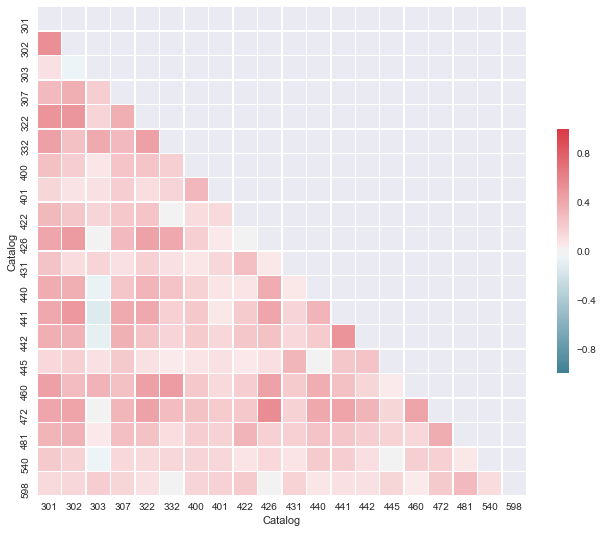

In [20]:
# Calculate correlation matrix
corr = grades.corr()
# Create a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up plot
f, ax = plt.subplots(figsize=(11,9))
# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

It can be hard to tell just how much correlation there is with a colormap. Below, we print the actual values using some basic CSS styling through Pandas. All correlations above 0.50 or below -0.50 are highlighted in red. This view makes it much more obvious that we don't have too much cause for concern.

In [21]:
def high_corr_red(value):
    """Returns a string with the css property `'color: red'` for values over >= 0.50 or <= -0.50."""
    color = 'red' if value != 1 and (value >= 0.50 or value <= -0.50) else 'black'
    return 'color: %s' % color

# Chaining multiple styles together
corr_styled = corr.style.\
    applymap(high_corr_red).\
    format("{:.2}")
# Call to output
corr_styled

Catalog,301,302,303,307,322,332,400,401,422,426,431,440,441,442,445,460,472,481,540,598
Catalog,,,,,,,,,,,,,,,,,,,,
301,1.0,0.54,0.098,0.3,0.51,0.44,0.27,0.15,0.31,0.41,0.25,0.38,0.4,0.36,0.13,0.44,0.41,0.33,0.22,0.13
302,0.54,1.0,-0.049,0.36,0.5,0.27,0.2,0.084,0.23,0.47,0.12,0.36,0.49,0.35,0.18,0.29,0.43,0.35,0.17,0.14
303,0.098,-0.049,1.0,0.2,0.16,0.38,0.064,0.093,0.16,0.028,0.16,-0.066,-0.13,-0.086,0.089,0.34,0.016,0.049,-0.051,0.2
307,0.3,0.36,0.2,1.0,0.36,0.3,0.25,0.2,0.22,0.3,0.094,0.24,0.39,0.35,0.21,0.27,0.33,0.28,0.13,0.15
322,0.51,0.5,0.16,0.36,1.0,0.44,0.25,0.11,0.25,0.43,0.18,0.33,0.4,0.25,0.096,0.44,0.43,0.26,0.13,0.089
332,0.44,0.27,0.38,0.3,0.44,1.0,0.19,0.16,0.036,0.39,0.086,0.25,0.18,0.16,0.043,0.46,0.3,0.12,0.14,-0.017
400,0.27,0.2,0.064,0.25,0.25,0.19,1.0,0.32,0.12,0.19,0.064,0.18,0.22,0.21,0.073,0.23,0.26,0.2,0.16,0.16
401,0.15,0.084,0.093,0.2,0.11,0.16,0.32,1.0,0.13,0.05,0.14,0.075,0.062,0.14,0.087,0.13,0.21,0.18,0.14,0.17
422,0.31,0.23,0.16,0.22,0.25,0.036,0.12,0.13,1.0,0.0053,0.28,0.077,0.2,0.23,0.05,0.2,0.22,0.33,0.075,0.21


Still, it's not a bad idea to test PCA to see if there would be a benefit to reducing dimensionality. As can be seen in the output, a significant number of principal components would be needed to cover a majority of the variance in the data (e.g. 10 components to cover 80% of variance). This is not seen as a beneficial step to take, especially given that we would lose all interpretability with PCA.

Explained Variance
PC1: 33.50%
PC2: 10.78%
PC3:  7.70%
PC4:  5.65%
PC5:  4.62%
PC6:  4.36%
PC7:  4.14%
PC8:  3.80%
PC9:  3.27%
PC10:  3.20%
PC11:  3.03%
PC12:  2.71%
PC13:  2.33%
PC14:  2.23%
PC15:  2.10%
PC16:  1.94%
PC17:  1.52%
PC18:  1.29%
PC19:  0.97%
PC20:  0.84%


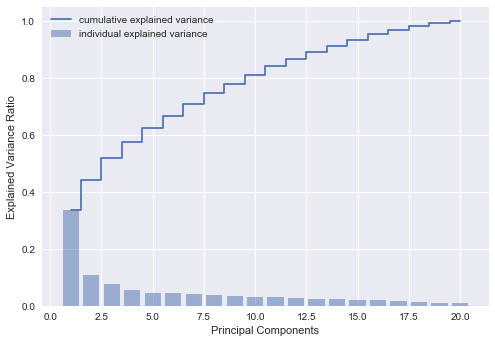

In [22]:
# Principal Component Analysis
pca = PCA(n_components=None)
grades_pca = pca.fit_transform(grades)
print('Explained Variance')
for pc in range(len(pca.explained_variance_ratio_)):
    print('PC{0}: {1:5.2f}%'.format(pc+1, pca.explained_variance_ratio_[pc]*100))
# Cumulative variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
# Plot it
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,len(pca.explained_variance_ratio_)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

## Inner Join of Data
We want to be sure that we are not retaining student data in one dataframe that does not exist in the others. So, we will perform an inner join of student IDs, and retain data only for those IDs moving forward.

In [23]:
# Multi-part operation:
# 1) Chain two merge statements together to produce an inner join on three dataframes
# 2) Keep only the "Student ID" field
# 3) Drop true duplicates
# 4) Reset index from 0
student_ids = nclex.merge(grades, left_index=True, right_index=True).merge(pa, left_index=True, right_on='Student ID')['Student ID'].drop_duplicates().reset_index(drop=True)

In [24]:
# Keep only the student IDs that are represented across all dataframes
grades = grades.ix[student_ids]
nclex = nclex.ix[student_ids]
pa = pa[pa['Student ID'].isin(student_ids)]

## Preparing the Predictive Assessment Data
The predictive testing product contained multiple categories of assessments (e.g. Medical/Surgical, Pediatrics, etc.) as well as multiple versions within each category containing different questions. Assessment and Assessment ID identify the assessment, and Booklet ID is a unique identifier for the test-taker. Date Taken identifies the date and time that the exam was begun.

For each assessment, several numerical scores are provided:
* Score (raw score)
* National Mean
* National Percentile
* Program Mean
* Program Percentile
* Proficiency Level (meant to indicate level of mastery; is based on a proprietary algorithm).

Each assessment is further broken down by section, where each section indicates a theoretical grouping of questions intended to provide an indication of the level of mastery of specific sub-topics. Numerical scores are provided both for the overall assessment and for each individual section.

In [25]:
pa.head()

,Assessment,Assessment ID,Booklet ID,Date Taken,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Section,Student ID
145314,RN Community Health 2010 Form A,50478,49403969,Mar 6 2013 8:27AM,65.46,99.0,Level 3,NaN,NaN,80.0,RN Community Health 2010 Form A,1359
145315,RN Community Health 2010 Form A,50478,49403969,Mar 6 2013 8:27AM,67.75,99.0,Below Level 1,NaN,NaN,90.0,Management of Care,1359
145316,RN Community Health 2010 Form A,50478,49403969,Mar 6 2013 8:27AM,28.13,99.0,Below Level 1,NaN,NaN,100.0,Advocacy,1359
145317,RN Community Health 2010 Form A,50478,49403969,Mar 6 2013 8:27AM,79.38,99.0,Below Level 1,NaN,NaN,100.0,Case Management,1359
145318,RN Community Health 2010 Form A,50478,49403969,Mar 6 2013 8:27AM,81.25,99.0,Below Level 1,NaN,NaN,100.0,Client Rights,1359


### Cleaning the Data
There are a few things we need to do to clean up the data so that it is easier to work with:
* Convert dates to datetime format so that we can perform calculations on them.
* Rename overall scores in each assessment to "Overall" rather than the same name as the assessment.
* Gather assessments into a few basic categories. Because the predictive testing vendor released new versions of the assessments every few years, in order to compare scores over time we need to know what these basic categories are.
* Represent Proficiency Level as an ordinal integer value.

In [26]:
# Convert string representation of 'Date Taken' to a python DateTime
pa['Date Taken'] = pd.to_datetime(pa['Date Taken'])

In [27]:
# Rename section headings that are 'overall' scores using a quick lambda function
def overall(Assessment, Section):
    if Section == Assessment:
        return 'Overall'
    else:
        return Section
pa['Section'] = pa.apply(lambda x: overall(x['Assessment'], x['Section']), axis=1)

In [28]:
# Create categories for all Assessments for comparison purposes using a dictionary and a lambda function.
# Students may take multiple assessments for each category.
def Categorize (string):
    # If the dictionary key appears in the Assessment Name, apply the dictionary value as the Category.
    kw_dict = {
               'Mental Health': 'Psych',
               'Comprehensive': 'Comprehensive',
               'Medical-Surgical': 'MedSurg',
               'Medical Surgical': 'MedSurg',
               'Fundamentals': 'Fundamentals',
               'Essential Academic Skills': 'Fundamentals',
               'Pharmacology': 'Pharm',
               'Maternal': 'OB',
               'Community Health': 'Community',
               'Leadership': 'Leadership',
               'Care of Children': 'Peds',
               'Critical Thinking': 'Critical Thinking'
               }
    for key in kw_dict:
        if key in string:
            return kw_dict[key]
pa['Category'] = pa.apply(lambda x: Categorize(x['Assessment']), axis=1)

In [29]:
# Convert Proficiency Levels to integer values using a dictionary mapping.
proficiency_map = {'Below Level 1': 0,
                   'Level 1': 1,
                   'Level 2': 2,
                   'Level 3': 3                   
                   }
pa['Proficiency Level'] = pa['Proficiency Level'].map(proficiency_map)

### Removing Duplicates
Before we can run any kind of analysis, we need to remove duplicates from our data. Some duplicates are true duplicates (all fields duplicated), so those are dropped without any loss of data. There also appears to be some malformed data, where everything is duplicated but all of the numeric scores are lost (value = 'Nan'). Again, these are dropped without any loss of data.

In [30]:
# Drop true duplicates
pa = pa.drop_duplicates()

In [31]:
# Drop NaN in National Percentile and/or National Mean (only accompanies malformed duplicates)
pa = pa.dropna(axis=0,how='any',subset=['National Percentile'])
pa = pa.dropna(axis=0,how='any',subset=['National Mean'])

### Missing Values
We will need a plan for dealing with any missing values before we can run any analysis. First, let's take a look at where our missing values reside.

In [32]:
# Which columns contain NaNs?
pa.isnull().sum()

Assessment                 0
Assessment ID              0
Booklet ID                 0
Date Taken                 0
National Mean              0
National Percentile        0
Proficiency Level      28919
Program Mean            6885
Program Percentile      6885
Score                      0
Section                    0
Student ID                 0
Category                   0
dtype: int64

#### Impute Missing Values for Program Mean
Missing values in Program Mean are clustered in two specific assessments. Because we have almost 7,000 NaNs, and we don't want to have to drop this data when modeling, we will impute the missing values. Program Mean should be very simple to impute, however, since it should just be a mean value of all the scores for a particular section of a particular assessment. In order to get a little more granular than just replacing NaNs with the mean of the entire column (which wouldn't account for differences in sections or assessments), we will iterate over each section to impute mean values.

In [33]:
# First, let's look at the data.
# We make a copy of the df to avoid making unwanted changes
Prog_Nans = pa.copy(deep=True)
Prog_Nans = Prog_Nans[Prog_Nans['Program Mean'].isnull()]
Prog_Nans.head()

,Assessment,Assessment ID,Booklet ID,Date Taken,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Section,Student ID,Category
145314,RN Community Health 2010 Form A,50478,49403969,2013-03-06 08:27:00,65.46,99.0,3.0,NaN,NaN,80.0,Overall,1359,Community
145315,RN Community Health 2010 Form A,50478,49403969,2013-03-06 08:27:00,67.75,99.0,0.0,NaN,NaN,90.0,Management of Care,1359,Community
145316,RN Community Health 2010 Form A,50478,49403969,2013-03-06 08:27:00,28.13,99.0,0.0,NaN,NaN,100.0,Advocacy,1359,Community
145317,RN Community Health 2010 Form A,50478,49403969,2013-03-06 08:27:00,79.38,99.0,0.0,NaN,NaN,100.0,Case Management,1359,Community
145318,RN Community Health 2010 Form A,50478,49403969,2013-03-06 08:27:00,81.25,99.0,0.0,NaN,NaN,100.0,Client Rights,1359,Community


In [34]:
# These NaNs are clustered in the Community Health assessments
Prog_Nans['Assessment'].unique()

array(['RN Community Health 2010 Form A'], dtype=object)

In [35]:
# Closer look at missing values
for assessment in Prog_Nans['Assessment'].unique():
    NaNs = len(pa[(pa['Assessment'] == assessment) & (pa['Program Mean'].isnull())])
    Total = len(pa[(pa['Assessment'] == assessment)])
    print('Assessment: {}'.format(assessment))
    print('{0:5d} NaNs / {1:5d} Total = {2:6.2f}% Missing'.format(NaNs, Total, (NaNs/Total)*100))

Assessment: RN Community Health 2010 Form A
 6885 NaNs /  6885 Total = 100.00% Missing


In [36]:
# Initialize the mean_imputer (axis=0 means it will impute mean of column)
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [37]:
# Iterate through each section of each assessment (for localized means)
for assessment in Prog_Nans['Assessment'].unique():
    for section in Prog_Nans[Prog_Nans['Assessment'] == assessment]['Section'].unique():
        # Copy df and remove unnecessary features
        impute_df = Prog_Nans.copy(deep=True)
        impute_df = impute_df[(impute_df['Assessment'] == assessment) & (impute_df['Section'] == section)]
        impute_df = impute_df[['Program Mean', 'Score']]
        # Fit and transform imputer
        impute_df['Program Mean'] = mean_imputer.fit_transform(impute_df)
        # Add imputed values to df using fillna
        pa['Program Mean'].fillna(value=impute_df['Program Mean'], inplace=True)

#### Impute Missing Values for Program Percentile
Missing values for Program Percentile should be easy to compute now that we have all of the Program Means. We'll use scipy's percentileofscore function to generate our percentiles. Again, we want to calculate percentiles for each section of each assessment. We want to apply a function over each row of a Pandas dataframe, but we need to be careful to pass both the full range of scores and a single score to each call of the percentile function.

In [38]:
# Copy df where Program Percentile is NaN
Percentile_Nans = pa.copy(deep=True)
Percentile_Nans = Percentile_Nans[Percentile_Nans['Program Percentile'].isnull()]

In [39]:
# Note that in this function we need to take the score for each observation and determine the percentile against
# the overall range of scores. So the first argument in percentileofscore is not taken row by row.
def percentile(row):
    'A simple function to calculate percentiles'
    return percentileofscore(impute_df['Score'], row['Score'])

In [40]:
# Iterate through each section of each assessment (localized percentiles)
for assessment in Percentile_Nans['Assessment'].unique():
    for section in Percentile_Nans[Percentile_Nans['Assessment'] == assessment]['Section'].unique():
        # Copy df and remove unnecessary features
        impute_df = Percentile_Nans.copy(deep=True)
        impute_df = impute_df[(impute_df['Assessment'] == assessment) & (impute_df['Section'] == section)]
        impute_df = impute_df[['Program Percentile', 'Score']]
        # Apply percentile function
        impute_df['Program Percentile'] = impute_df.apply(percentile, axis=1)
        # Add imputed values
        pa['Program Percentile'].fillna(value=impute_df['Program Percentile'], inplace=True)

In [41]:
# Which columns still contain NaNs?
pa.isnull().sum()

Assessment                 0
Assessment ID              0
Booklet ID                 0
Date Taken                 0
National Mean              0
National Percentile        0
Proficiency Level      28919
Program Mean               0
Program Percentile         0
Score                      0
Section                    0
Student ID                 0
Category                   0
dtype: int64

#### Impute Missing Values for Proficiency Level
Proficiency level is not based simply on a cutoff value of the raw score for a test, but is a proprietary algorithm. Proficiency levels change over time and are different for different assessments. Proficiency levels for similar performances on similar exams, however, should be the similar. For this reason, we will implement K-Nearest Neighbors to impute the missing values.

In [42]:
# Percent of data missing for Proficiency Level
NaNs = pa['Proficiency Level'].isnull().sum()
Total = pa.shape[0]
print('Proficiency Level: {0:5d} NaNs / {1:6d} Total = {2:5.2f}% Missing'.format(NaNs, Total, (NaNs/Total)*100))

Proficiency Level: 28919 NaNs / 134533 Total = 21.50% Missing


In [43]:
# Create a subset of data that contains class labels for Proficiency level
x = pa[(pa['Proficiency Level'].notnull())]
# Drop non-numeric data and any other data which can't be used in the KNN classifier
x = x.drop(['Date Taken', 'Student ID', 'Assessment', 'Section', 'Category', 'Assessment ID', 'Booklet ID'], axis=1)
# Drop any lingering NaNs that might be in the data
x = x.dropna()

In [44]:
# Separate the target variable
y = x['Proficiency Level'].as_matrix().astype(int)
x = x.drop(['Proficiency Level'], axis=1)

In [45]:
#Use train test split for cross-validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [46]:
# Pre-scale the data (scale separately to avoid "cheating")
x_train_scaled = scale(x_train)
x_test_scaled = scale(x_test)

In [47]:
# Use a grid search to determine the best parameter (number of neighbors)
k = list(range(3,21,3))
params = {'n_neighbors': k,
          }

In [48]:
# Initialize K-Nearest Neighbors
knn_clf = KNeighborsClassifier()

In [49]:
# Hyperparameter tuning using GridSearchCV
# Use f1 scoring to balance precision and recall. Use weighted because we have large class imbalance.
knn_gs = GridSearchCV(knn_clf, param_grid=params, scoring='f1_weighted', cv=5)
knn_gs.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 6, 9, 12, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=0)

In [50]:
# Best score (F1-weighted)
knn_gs.best_score_

0.99747056817624169

In [51]:
# Best estimator
knn_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [52]:
# Save the best estimator to a function
knn_best = knn_gs.best_estimator_

As we can see from the confusion matrix and classification report below, our KNN model is very accurate at predicting each of the four classifications for Proficiency level. We achieve both high precision and high recall, giving us confidence that KNN will be a good method to impute missing values. KNN should be much more accurate than simply taking the mode of the data or the most recent value.

In [53]:
# View Confusion Matrix and Classification Report
knn_best.fit(x_train, y_train)
y_pred = knn_best.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[30445     3     2     7]
 [   14   377     3     0]
 [   22     5   602     2]
 [    9     0     5   189]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     30457
          1       0.98      0.96      0.97       394
          2       0.98      0.95      0.97       631
          3       0.95      0.93      0.94       203

avg / total       1.00      1.00      1.00     31685



In [54]:
#Impute NaNs for Proficiency Level
x_impute = pa[(pa['Proficiency Level'].isnull())]
x_impute = x_impute.drop(['Date Taken', 'Student ID', 'Assessment', 'Section', 'Category', 'Assessment ID', 'Booklet ID'], axis=1)
x_impute['Proficiency Level'] = knn_best.predict(x_impute[['National Mean','National Percentile','Program Mean','Program Percentile','Score']])

In [55]:
#Add imputed values to df using fillna
pa['Proficiency Level'].fillna(x_impute['Proficiency Level'], inplace=True)

In [56]:
# Which columns still contain NaNs?
pa.isnull().sum()

Assessment             0
Assessment ID          0
Booklet ID             0
Date Taken             0
National Mean          0
National Percentile    0
Proficiency Level      0
Program Mean           0
Program Percentile     0
Score                  0
Section                0
Student ID             0
Category               0
dtype: int64

### Create New Features
Intuitively, we can expect that some of our numeric features will be highly correlated with one another. We will check this for ourselves in a moment, but first let's see if combining some features might help to capture more variance in fewer features. Here, we'll calculate a simple distance to to the National Mean and Program Mean.

Again, intuitively, we might expect these features, especially Distance to the National Mean, to match very well with our overall prediction of NCLEX success. To understand why, we need to understand more about the NCLEX.

In [57]:
# Calculate distance to National Mean
pa['Dist to National Mean'] = pa.apply(lambda x: x['Score'] - x['National Mean'],axis=1)

# Calculate distance to Program Mean
pa['Dist to Program Mean'] = pa.apply(lambda x: x['Score'] - x['Program Mean'],axis=1)

#### A Brief Detour into the NCLEX
The NCLEX uses Computerized Adaptive Testing (CAT), which displays questions to candidates in a way that attempts to understand each candidate's ability while using as few questions as possible. A standard exam requires all candidates to answer the same questions, while CAT attempts to always display questions that a candidate should find challenging (based on his or her ability). 

But how can the NCLEX know how challenging each question is? The answer is that questions must be tested ahead of time across a wide sample of respondents. This is the first instance where something similar to a "National Mean" plays a role in determining pass rate.

The second instance is in the actual decision rules of whether a candidate passes or fails. The passing standard is based, at least partially, on past NCLEX results, sample test-takers, and education readiness of high-school graduates interested in nursing. All of these are related to a National Mean.

### Standardize Numeric Values
For most machine learning algorithms, we want to pass standardized numeric values so that we do not give too much emphasis to features with very large maximum values or very wide ranges.

Given the type of data that we have (no negative values, and both a min and a max that have real meaning), using SciKit Learn's StandardScaler would be the wrong choice. By forcing the data to center at 0 with a standard deviation of 1, we would create negative values and lose any inherent meaning in "0" as a test score or a percentile. The MinMaxScaler, on the other hand, will preserve both of these features.

In [58]:
# Scale numeric data using the MinMaxScaler
min_max_scaler = MinMaxScaler()
pa[['National Mean', 'National Percentile', 'Program Mean', 'Program Percentile', 'Score', 'Dist to National Mean', 'Dist to Program Mean']] = min_max_scaler.fit_transform(pa[['National Mean', 'National Percentile', 'Program Mean', 'Program Percentile', 'Score', 'Dist to National Mean', 'Dist to Program Mean']])

In [59]:
# Proof that our scaling worked
pa.describe(include=[np.float])

,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Dist to National Mean,Dist to Program Mean
count,134533.000000,134533.000000,134533.000000,134533.000000,134533.000000,134533.000000,134533.000000,134533.000000
mean,0.626741,0.703299,0.089532,0.672169,0.682016,0.693176,0.550292,0.546523
std,0.150885,0.322488,0.423430,0.140552,0.318684,0.328152,0.177796,0.173748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544790,0.428571,0.000000,0.597900,0.417717,0.500000,0.459742,0.464138
50%,0.625945,0.816327,0.000000,0.671100,0.769094,0.750000,0.583919,0.571531
75%,0.719613,1.000000,0.000000,0.752000,0.989961,1.000000,0.676498,0.667329
max,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Recast Data
Several of our columns contain numerals, but should not be treated as either floats or integers. For example, we will never want to perform arithmetic on Student ID. For these columns, it would be much better to recast as type numpy.object.

In [60]:
# Recast data
pa = pa.astype({'Assessment ID': np.object, 'Booklet ID': np.object, 'Student ID': np.object, 'Proficiency Level': np.int})

In [61]:
# Review resulting data types
pa.dtypes

Assessment                       object
Assessment ID                    object
Booklet ID                       object
Date Taken               datetime64[ns]
National Mean                   float64
National Percentile             float64
Proficiency Level                 int64
Program Mean                    float64
Program Percentile              float64
Score                           float64
Section                          object
Student ID                       object
Category                         object
Dist to National Mean           float64
Dist to Program Mean            float64
dtype: object

### Was an Assessment Proctored?
The predictive testing vendor provides multiple versions of each assessment. Typically, only one of these assessments will be treated as a proctored exam requiring all students to test at the same time. The proctored exam is likely to be the most important for our purposes, as it will be the only assessment for which we can be sure of the seriousness of the testing environment. 

Students are able to take other versions of the assessment as practice. While this might provide us with important data, it would be helpful to be able to identify the difference between a proctored and a non-proctored exam.

Finally, there are also situations in which students are required to take a proctored assessment at a time other than when the rest of their cohort took the exam. This could be a re-scheduling situation, or it could be required remediation. In the former case, we would want to group the exam with the regular proctored assessment. In the latter case, a re-test in which the student improves their score might be an important indication.

Because there is no true indicator for whether or not an assessment was proctored, we will make the following assumptions:
* If a student only took one assessment in a category, it was a proctored exam.
* If a student took more than one assessment in a category, the one with the most concurrent candidates was a proctored exam.
* For all other assessments, if 3 or more students took the assessment on the same day, it was a proctored retake. The rest are non-proctored practice.

In [62]:
# We create a subset of the full dataset to make storing values quicker
overall_df = pa.copy(deep=True)
overall_df = overall_df.drop_duplicates(subset=['Assessment ID', 'Booklet ID'])

In [63]:
# We will start by making a dictionary to store counts of assessments taken on a given day.
Assessments_by_Date = {}
# Create a list of all possible assessments and iterate through that list
assessments = overall_df['Assessment'].unique().tolist()
for assessment in assessments:
    # List of all dates on which that assessment was taken
    dates = overall_df[overall_df['Assessment'] == assessment]['Date Taken'].dt.date.unique().tolist()
    for date in dates:
        # Create a tuple as the dictionary key
        key = (assessment, date)
        # The dictionary value will be the number of unique test takers
        Assessments_by_Date[key] = len(overall_df[(overall_df['Assessment'] == assessment) & (overall_df['Date Taken'].dt.date == date)]['Student ID'].unique())

In [64]:
# Next we will make a dictionary to store the number of assessments each student took in each category
Assessments_by_Category = {}
# Create a list of all students and iterate through that list
students = overall_df['Student ID'].unique().tolist()
for student in students:
    # List all categories
    categories = overall_df[overall_df['Student ID'] == student]['Category'].unique().tolist()
    for category in categories:
        # Create a tuple as the dictionary key
        key = (student, category)
        # The dictionary value will be a tuple of (Assessment, Date Taken)
        Assessments_by_Category[key] = tuple(zip(overall_df[(overall_df['Student ID'] == student) & (overall_df['Category'] == category)]['Assessment'],
                                                 overall_df[(overall_df['Student ID'] == student) & (overall_df['Category'] == category)]['Date Taken'].dt.date.unique().tolist()))

In [65]:
# A simple function to look up dictionary values and return a result
def Modality (row):
    # If there is only one assessment in a category, mark as the Proctored Exam
    if len(Assessments_by_Category[(row['Student ID'], row['Category'])]) == 1:
        return 'Proctored Exam'
    else:
        # Store the (Assessment, Date Taken) tuples in a category
        all_dates = Assessments_by_Category[(row['Student ID'], row['Category'])]
        # Sort tuples by Date Taken
        all_dates = sorted(all_dates, key=lambda x: x[1])
        # Create a list of the number of candidates who took each assessment on each date
        all_candidates = [Assessments_by_Date[x] for x in all_dates]
        # Find the index of the assessment with the max number of candidates
        max_candidates_index = np.argmax(all_candidates)
        # The one with the most candidates will be the Proctored Exam
        if (row['Assessment'], row['Date Taken'].date()) == all_dates[max_candidates_index]:
            return 'Proctored Exam'
        else:
            # If there were 3 or more candidates, mark as Proctored Retake
            if Assessments_by_Date[(row['Assessment'], row['Date Taken'].date())] >= 3:
                return 'Proctored Retake'
            # Else, it's practice
            else:
                return 'Non-proctored Practice'

In [66]:
# Define a new dataset feature
pa['Modality'] = pa.apply(Modality, axis=1)

In [67]:
# Show the value counts to see a quick distribution
pa['Modality'].value_counts()

Proctored Exam            112369
Proctored Retake           19693
Non-proctored Practice      2471
Name: Modality, dtype: int64

### Drop Features No Longer Needed
* We will drop both National Mean and Program Mean, as these are not student-specific values, but aggregates. As such, we can't include in any model building.
* We also drop Booklet ID and the integer version of our Assessment ID.

In [68]:
# Drop features
pa = pa.drop(['National Mean', 'Program Mean', 'Assessment ID', 'Booklet ID'], axis=1)

### Reshape Data from Long to Wide Format
At this point, we will only continue working with proctored exam data and the overall scores. Future work could explore the usefulness of practice exams or remediation scores, as well as the individual section scores.

In [69]:
# Take only the Proctored Exams
pa = pa[pa['Modality'] == 'Proctored Exam'].copy(deep=True)

As it turns out, we still have a small amount of duplicated data. If we take a closer look, we can see that these are true duplicates except for having a slightly different time value in the Date Taken column. This appears to be a simple inconsistency in the data, likely introduced when we dropped an unneeded variable such as "Class." We can remove one of the values with no real loss of data.

In [70]:
# Find duplicates and keep all duplicates so that we can review
df_wide_dupe = pa.duplicated(subset=['Student ID', 'Category', 'Section'], keep=False)

In [71]:
# 'True' indicates a duplicate
df_wide_dupe.value_counts()

False    112241
True        128
dtype: int64

In [72]:
# Drop duplicates
pa = pa.drop_duplicates(subset=['Student ID', 'Category', 'Section'], keep='first')

In [73]:
# For now, keep only the overall section scores
pa = pa[pa['Section'] == 'Overall']

In [74]:
# Unstack the data by Category
pa = pa.set_index(['Student ID', 'Category']).unstack('Category')

In [75]:
pa.head()

Assessment  \
Category                          Community   
Student ID                                    
1           RN Community Health 2010 Form A   
4           RN Community Health 2010 Form A   
5           RN Community Health 2010 Form A   
6                  RN Community Health 2013   
15          RN Community Health 2010 Form A   

                                                    \
Category                             Comprehensive   
Student ID                                           
1           RN Comprehensive Predictor 2013 Form B   
4           RN Comprehensive Predictor 2013 Form B   
5           RN Comprehensive Predictor 2013 Form B   
6                  RN Comprehensive Predictor 2016   
15          RN Comprehensive Predictor 2010 Form B   

                                                    \
Category                         Critical Thinking   
Student ID                                           
1           Critical Thinking Assessment: Entrance   
4           Critical Thinking Assessment: Entrance   
5           Critical Thinking Assessment: Entrance   
6           Critical Thinking Assessment: Entrance   
15          Critical Thinking Assessment: Entrance   

                                         \
Category                   Fundamentals   
Student ID                                
1           RN Fundamentals 2010 Form B   
4           RN Fundamentals 2010 Form B   
5           RN Fundamentals 2010 Form B   
6                  RN Fundamentals 2013   
15          RN Fundamentals 2010 Form B   

                                                   \
Category                                  MedSurg   
Student ID                                          
1           RN Adult Medical Surgical 2010 Form B   
4           RN Adult Medical Surgical 2010 Form B   
5           RN Adult Medical Surgical 2010 Form B   
6                                            None   
15          RN Adult Medical Surgical 2010 Form B   

                                             \
Category                                 OB   
Student ID                                    
1           RN Maternal Newborn 2010 Form B   
4           RN Maternal Newborn 2010 Form B   
5           RN Maternal Newborn 2010 Form B   
6                  RN Maternal Newborn 2013   
15          RN Maternal Newborn 2010 Form B   

                                                     \
Category                                       Peds   
Student ID                                            
1           RN Nursing Care of Children 2010 Form B   
4           RN Nursing Care of Children 2010 Form B   
5           RN Nursing Care of Children 2010 Form B   
6                  RN Nursing Care of Children 2013   
15          RN Nursing Care of Children 2010 Form B   

                                                                       \
Category                          Pharm                         Psych   
Student ID                                                              
1           RN Pharmacology 2013 Form B  RN Mental Health 2010 Form B   
4           RN Pharmacology 2013 Form B  RN Mental Health 2010 Form B   
5           RN Pharmacology 2013 Form B  RN Mental Health 2010 Form B   
6                  RN Pharmacology 2013         RN Mental Health 2013   
15          RN Pharmacology 2010 Form B  RN Mental Health 2010 Form B   

                    Date Taken       ...       Dist to Program Mean  \
Category             Community       ...                      Psych   
Student ID                           ...                              
1          2014-02-26 11:36:00       ...                   0.553200   
4          2014-05-21 14:36:00       ...                   0.525592   
5          2014-02-26 11:37:00       ...                   0.562421   
6          2016-03-02 15:58:00       ...                   0.613715   
15         2013-05-29 13:49:00       ...                   0.599194   

                  Modality                      

### Impute Missing Values for Numeric Data
Now that we have data in a wide format, we can easily see that there are some missing values. Not every student took an assessment in every category. Some of these exams were used for only a short period of time, while others have close to 100% data. We need to impute data for any features that we expect to use in model building.

In [76]:
# A count of missing values for each assessment category
pa['Assessment'].isnull().sum()

Category
Community              0
Comprehensive         55
Critical Thinking      4
Fundamentals           1
MedSurg              109
OB                     0
Peds                   0
Pharm                 36
Psych                  1
dtype: int64

In [77]:
# Lists of categories and numeric columns
categories = list(pa.columns.get_level_values(1).unique())
numeric_columns = ['National Percentile', 'Program Percentile', 'Score', 'Dist to National Mean', 'Dist to Program Mean']

We have to jump through a few hoops to use the fillna method on a single column in a multi-index, but it is important that we do not use the same imputing strategy for numeric and categorical data. We will first impute the values for Proficiency Level using the mode for each assessment category. Notice that this case is different from before - in this case we have no data upon which to base a Proficiency Level, whereas before we had a full set of data with only the Proficiency Level missing. We use the update method because inplace does not work with .loc, and here we need to be able to access a particular subset of the data.

In [78]:
# Iterate through categories to impute missing values for Proficiency Level
for category in categories:
    pa.update(pa.loc[:, [('Proficiency Level', category)]].fillna(pa.loc[:, [('Proficiency Level', category)]].mode().values[0][0]))

In [79]:
# Ensure there are no more NaNs in Proficiency Level
pa['Proficiency Level'].isnull().sum()

Category
Community            0
Comprehensive        0
Critical Thinking    0
Fundamentals         0
MedSurg              0
OB                   0
Peds                 0
Pharm                0
Psych                0
dtype: int64

In [80]:
# Fill NaNs in numeric columns with the mean of the column for numeric data
pa.fillna(pa.mean(), inplace=True);

In [81]:
# Check to see that there are no more missing values
pa[numeric_columns].isnull().sum()

                       Category         
National Percentile    Community            0
                       Comprehensive        0
                       Critical Thinking    0
                       Fundamentals         0
                       MedSurg              0
                       OB                   0
                       Peds                 0
                       Pharm                0
                       Psych                0
Program Percentile     Community            0
                       Comprehensive        0
                       Critical Thinking    0
                       Fundamentals         0
                       MedSurg              0
                       OB                   0
                       Peds                 0
                       Pharm                0
                       Psych                0
Score                  Community            0
                       Comprehensive        0
                       Critical Thinkin

## Reviewing for Correlations and Covariance
For each student / assessment category pairing, we have the following six data points:

* Raw Score
* National Percentile
* Program Percentile
* Proficiency Level
* Distance from National Mean
* Distance from Program Mean

As can be shown, many of these data points for a specific subject area are highly correlated to one another. This makes intuitive sense, as the raw score would be used to calculate all other data points.

In the correlation matrix below, the noticeable diagonal bands indicate the high correlation between the numeric data points for each subject.

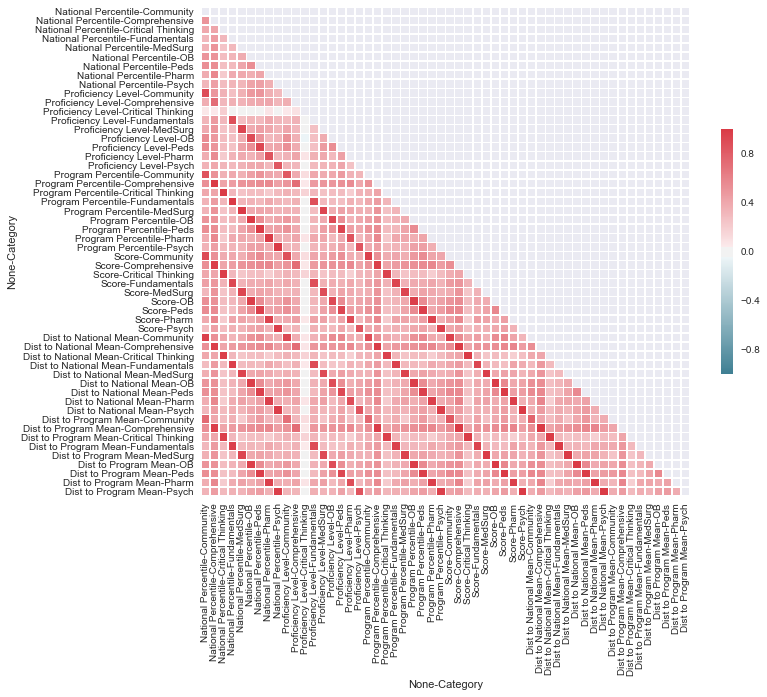

In [82]:
# Calculate correlation matrix
corr = pa.corr()
# Create a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up plot
f, ax = plt.subplots(figsize=(11,9))
# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

If we take a closer look at some of the actual correlation values, we can see that the numeric data is close to being perfectly correlated with all values above 0.90. Given the high amount of correlation, it will be necessary to remove features from our dataset before we can engage in model building. Otherwise, we risk major issues due to covariance. Removing features should also help with computation time and with interpretability.

In [83]:
# Separate out the data for Comprehensive assessments
comprehensive = pa.loc[:, pa.columns.get_level_values(1)=='Comprehensive']
# Calculate correlation matrix
corr = comprehensive.corr()

# Chaining multiple styles together
corr_styled = corr.style.\
    applymap(high_corr_red).\
    format("{:.2}")
# Call to output
corr_styled

,,National Percentile,Proficiency Level,Program Percentile,Score,Dist to National Mean,Dist to Program Mean
,Category,Comprehensive,Comprehensive,Comprehensive,Comprehensive,Comprehensive,Comprehensive
,Category,,,,,,
National Percentile,Comprehensive,1.0,0.72,1.0,0.97,0.98,0.98
Proficiency Level,Comprehensive,0.72,1.0,0.72,0.72,0.73,0.73
Program Percentile,Comprehensive,1.0,0.72,1.0,0.98,0.98,0.98
Score,Comprehensive,0.97,0.72,0.98,1.0,1.0,1.0
Dist to National Mean,Comprehensive,0.98,0.73,0.98,1.0,1.0,1.0
Dist to Program Mean,Comprehensive,0.98,0.73,0.98,1.0,1.0,1.0


## Examining Feature Importance
Due to high covariance in the numeric features, we would like to see if it is possible to identify what the most important features are for model building. We will start by using random forests. 

If we cycle through one category at a time, we can see that feature importance varies by category. Distance to National Mean is a consistently strong performer, and this feature make intuitive sense when we consider that the NCLEX is a nationally standardized exam. 

Simply choosing one feature may not capture as much variance as we would want, though.

In [84]:
# Convert numeric_columns list to numpy array for indexing purposes
feat_list = np.array(numeric_columns)
# Iterate through categories
for category in categories:
    # Grab numeric data in the particular category
    df_features = pa.loc[:, pa.columns.get_level_values(1)==category][feat_list]
    # Fit forest
    forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
    forest.fit(df_features, nclex['Result'])
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print importances
    print('Category: {}'.format(category))
    for f in range(df_features.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, feat_list[indices[f]], importances[indices[f]]))

Category: Community
 1) Program Percentile             0.339158
 2) Score                          0.237573
 3) National Percentile            0.188584
 4) Dist to National Mean          0.157730
 5) Dist to Program Mean           0.076955
Category: Comprehensive
 1) Dist to National Mean          0.244719
 2) Dist to Program Mean           0.231406
 3) Program Percentile             0.207649
 4) National Percentile            0.177371
 5) Score                          0.138855
Category: Critical Thinking
 1) Score                          0.205512
 2) National Percentile            0.202068
 3) Dist to National Mean          0.201892
 4) Program Percentile             0.201539
 5) Dist to Program Mean           0.188988
Category: Fundamentals
 1) Dist to National Mean          0.260777
 2) Score                          0.255704
 3) Program Percentile             0.184239
 4) National Percentile            0.153670
 5) Dist to Program Mean           0.145610
Category: MedSurg
 1) Dis

## Reducing Dimensionality
We can use Principal Component Analysis to reduce dimensionality while maintaining an acceptable threshold of variance. As we can see in the example below, which looks at numeric data in the Comprehensive assessment, a major portion of the overall variance can be captured in a single principal component. This is not surprising given our correlations.

While Principal Component Analysis is sure to capture more variance than manually selecting one feature, we would be sacrificing interpretability.

Explained Variance
PC1: 99.42%
PC2:  0.48%
PC3:  0.08%
PC4:  0.01%
PC5:  0.00%


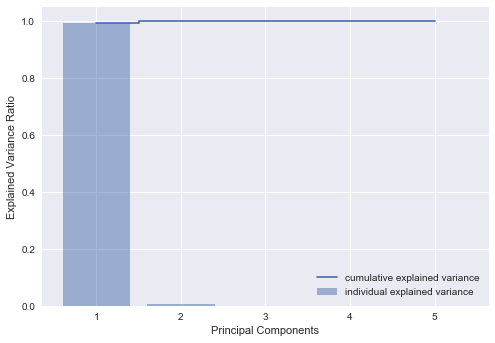

In [85]:
# Principal Component Analysis
pca = PCA(n_components=None)
pa_pca = pca.fit_transform(df_features)
print('Explained Variance')
for pc in range(len(pca.explained_variance_ratio_)):
    print('PC{0}: {1:5.2f}%'.format(pc+1, pca.explained_variance_ratio_[pc]*100))
# Cumulative variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
# Plot it
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,len(pca.explained_variance_ratio_)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

## Performing Manual Feature Selection

In [86]:
pa_saved = pa.copy(deep=True)

In [87]:
pa = pa['Dist to National Mean']

# Preparing Our Data for Final Modeling
At this point, we will identify a general ordering for the data, based on the curriculum of the nursing program, where each numerical value indicates the academic term in which the student would be expected to produce the data.

## Mapping Courses and Categories to a Term

In [88]:
# Initialize dictionary to store term lists
term_map = {'courses': {}, 'categories': {}}

# Courses
term_map['courses']['fall_2011'] = {1:['301', '322', '332', '431'],
                                    2:['302', '400', '422'],
                                    3:['303', '401', '481'],
                                    4:['307', '460'],
                                    5:['440', '441', '540'],
                                    6:['442', '445', '472'],
                                    7:['426', '598']}
term_map['courses']['fall_2015'] = {1:['322', '332', '431'],
                                    2:['301', '400', '422'],
                                    3:['302', '481', '540'],
                                    4:['303', '460'],
                                    5:['307', '401', '445'],
                                    6:['440', '441'],
                                    7:['442', '472'],
                                    8:['426', '598']}

# Predictive Assessment Categories
term_map['categories']['fall_2011'] = {1:['Critical Thinking', 'Fundamentals'],
                                       2:[],
                                       3:['MedSurg'],
                                       4:['Psych'],
                                       5:['OB', 'Peds'],
                                       6:['Community'],
                                       7:['Pharm', 'Comprehensive']}
term_map['categories']['fall_2015'] = {1:['Critical Thinking'],
                                       2:['Fundamentals'],
                                       3:[],
                                       4:['MedSurg'],
                                       5:['Psych'],
                                       6:['OB', 'Peds'],
                                       7:['Community'],
                                       8:['Pharm', 'Comprehensive']}

## Pulling Data by Term
To cut down on the amount of variable names (and the resulting confusion), we will create a nested dictionary where the first level is the academic term. As we progress through each term, exam data will be added for each relevant term. On the second level of the dictionary, we will store:
* 'data': all feature data
* 'x_train': training split for feature data
* 'x_test': testing split for feature data
* 'y_train': training split for target data
* 'y_test': testing split for target data

As we begin model building, we will also store the results from models for easy access.

In [89]:
# Set Desired Curriculum Pattern
curriculum_pattern = 'fall_2011'
# Determine number of terms
number_of_terms = len(term_map['courses'][curriculum_pattern].keys())
# Combination Labels
combos = ['Grades', 'Predictive_Testing', 'Combined']

In [91]:
# Initialize dictionary
df_dict = {}
# Initialize level one labels
for item in combos:
    df_dict[item] = {}
    # Iterate through terms
    for term in range(1, number_of_terms+1):
        # Initialize level two labels
        df_dict[item][term] = {}
        
        # Gather data by term | Store in temporary df
        if item == 'Grades':
            temp_df = grades[term_map['courses'][curriculum_pattern][term]]
        elif item == 'Predictive_Testing':
            temp_df = pa[term_map['categories'][curriculum_pattern][term]]
        elif item == 'Combined':
            temp_df = grades[term_map['courses'][curriculum_pattern][term]].merge(pa[term_map['categories'][curriculum_pattern][term]], left_index=True, right_index=True)
    
        # In first term, assign temporary df to dictionary
        if term == 1:
            df_dict[item][term]['data'] = temp_df.copy(deep=True)
        # For all other terms, merge new data with previous data
        else:
            df_dict[item][term]['data'] = df_dict[item][term-1]['data'].merge(temp_df, left_index=True, right_index=True)
    
        # Train / Test Split
        x = df_dict[item][term]['data']
        y = nclex['Result']
        df_dict[item][term]['x_train'], df_dict[item][term]['x_test'], df_dict[item][term]['y_train'], df_dict[item][term]['y_test'] = train_test_split(x, y, test_size=0.3, random_state=25, stratify=y)

In [92]:
# Pickle the data for future use
with open('df_dict.pickle', 'wb') as f:
    pickle.dump(df_dict, f, pickle.HIGHEST_PROTOCOL)